In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

In [0]:
data_root = tf.keras.utils.get_file('flower_photos',
                                    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                    untar=True)

In [0]:
IMAGE_SHAPE = (224, 224)

In [4]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [5]:
for image_batch, label_batch in image_data:
    print('Image Batch shape: ', image_batch.shape)
    print('Label Batch shape: ', label_batch.shape)
    break

Image Batch shape:  (32, 224, 224, 3)
Label Batch shape:  (32, 5)


In [0]:
classifier_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

In [0]:
classifier = tf.keras.Sequential([
                                  hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [8]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=1)]
predicted_class_names

array(['daisy', 'bee', 'bee', 'daisy', 'bee', 'sea urchin', 'daisy',
       'cardoon', 'daisy', 'broccoli', "jack-o'-lantern", 'pot',
       'cardoon', 'sea urchin', 'hay', 'fountain', 'cardoon', 'mask',
       'rapeseed', 'fountain', 'leaf beetle', 'daisy', 'dragonfly',
       'stretcher', 'orange', 'daisy', 'cardoon', 'daisy', 'head cabbage',
       'shower curtain', 'daisy', 'bikini'], dtype='<U30')

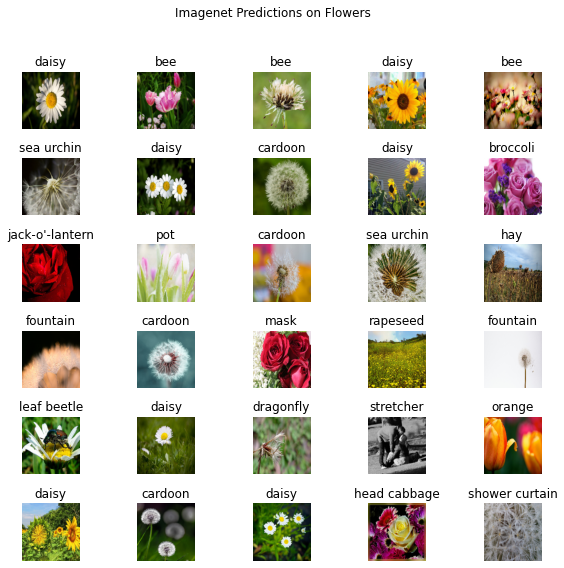

In [10]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
    plt.grid('off')
_ = plt.suptitle('Imagenet Predictions on Flowers')
plt.show()

In [0]:
headless_model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

In [0]:
feature_extractor_layer = tf.keras.Sequential([
                                               hub.KerasLayer(headless_model_url, input_shape=(224,224,3))
])

In [13]:
feature_extractor_layer.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
feature_batch = feature_extractor_layer.predict(image_batch)
feature_batch.shape

(32, 1280)

In [0]:
feature_extractor_layer.trainanble = False

In [16]:
model = tf.keras.Sequential([
                             feature_extractor_layer,
                             tf.keras.layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [17]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

In [0]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['acc'])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [20]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=3, steps_per_epoch=steps_per_epoch, callbacks=[batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/3
115/115 [==============================] - 15s 135ms/step - loss: 0.3115 - acc: 0.9062
Epoch 2/3
115/115 [==============================] - 15s 134ms/step - loss: 0.3538 - acc: 0.9062
Epoch 3/3
115/115 [==============================] - 15s 134ms/step - loss: 0.2487 - acc: 0.9375


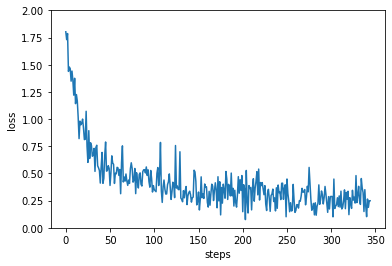

In [21]:
plt.figure()
plt.ylabel('loss')
plt.xlabel('steps')
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)
plt.show()

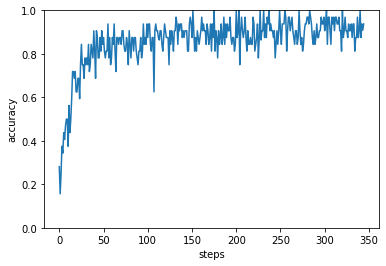

In [22]:
plt.figure()
plt.ylabel('accuracy')
plt.xlabel('steps')
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)
plt.show()

In [24]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair: pair[1])
class_names = np.array([key.title() for key, value in class_names])
print(class_names)

['Daisy' 'Dandelion' 'Roses' 'Sunflowers' 'Tulips']


In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=1)
predicted_label_batch = class_names[predicted_id]

In [0]:
label_id = np.argmax(label_batch, axis=-1)

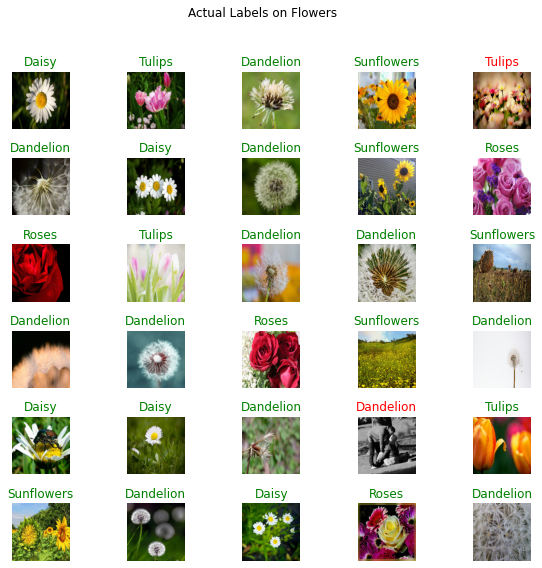

In [27]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = 'green' if predicted_id[n]==label_id[n] else 'red'
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle('Actual Labels on Flowers')
plt.show()

In [28]:
import time
t = time.time()

export_path = '/tmp/saved_models/{}'.format(int(t))
model.save(export_path, save_format='tf')

print(export_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/saved_models/1589355781/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1589355781/assets


/tmp/saved_models/1589355781


In [0]:
reloaded_model = tf.keras.models.load_model(export_path)

In [0]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded_model.predict(image_batch)

In [31]:
abs(reloaded_result_batch - result_batch).max()

0.0